# Portfolio value optimization
Suppose a portfolio manager has 100 possible projects and 10 disciplines a fixed budget distributed across the disciplines. The disciplines in turn have fixed human resources allocated to them that limits the number of labor hours available per discipline. Suppose after some analysis the portfolio manager has the following information:

1. A numerical ranking of the projects according to some uniform scale (e.g., net present value)
2. For each project a resource request per discipine in T-shirt size (not required = 0, low = 1, medium = 2, high = 3)

What would be the optimal resource planning for the projects? For this purpose one can define an objective function to optimize the business value and then use solver to find an optimum solution. This approach makes an assumption that there is a linear correlation between the investment in a project and the associated net present value. This assumption is highly questionable in practice. I perform a simulation and demonstrate how the portfolio returns can fluctuate based on slightly different boundary conditions. 

In [1]:
from ortools.linear_solver import pywraplp
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [2]:
# Define the function to specify the linear optimization problem as a matrix multiplication
def create_data(shape):
    array = np.random.randint(low = 0, high = 3, size = shape) # T-shirt size resource requests
    matrix_coeffs = array.tolist()
    constraints = np.random.choice(range(50,1000), size = shape[0]) # discipline budgets are between 50k and 1000k EUR
    constraints = constraints.tolist()
    objective_coeffs = np.random.choice(range(0,100), size = shape[1]) # project ranking is between 0 and 100
    objective_coeffs = objective_coeffs.tolist()

    data = {}
    data['matrix_coeffs'] = matrix_coeffs
    data['constraints'] = constraints
    data['objective_coeffs'] = objective_coeffs

    # Deduce the number of variables and constraints
    data['n_constraints'],  data['n_variables'] = array.shape
    
    return data

In [3]:
# Define the optmization function; use the 'verbose' parameter to print the verbose result
def solve(data, verbose = 0):
    solver = pywraplp.Solver.CreateSolver('GLOP') # Create the linear solver with the GLOP backend
    # solver = pywraplp.Solver.CreateSolver('SCIP') # Create the mixed-integer programming solver with the SCIP backend
    infinity = solver.infinity()
    x = {}
    for j in range(data['n_variables']):
        x[j] = solver.IntVar(0, infinity, 'x[%i]' % j)
    # print('Number of variables =', solver.NumVariables())

    for i in range(data['n_constraints']):
        constraint = solver.RowConstraint(0, data['constraints'][i], '')
        for j in range(data['n_variables']):
            constraint.SetCoefficient(x[j], data['matrix_coeffs'][i][j])
    # print('Number of constraints =', solver.NumConstraints())

    objective = solver.Objective()
    for j in range(data['n_variables']):
        objective.SetCoefficient(x[j], data['objective_coeffs'][j])
        objective.SetMaximization()

    status = solver.Solve()
    portfolio_budget = 0
    optimum = -1
    solution_values = []
    if verbose == 1 and status == pywraplp.Solver.OPTIMAL:
        print(F'Overall optimum value = {round(solver.Objective().Value(), 2)}\n')
        portfolio_budget = round(sum(data['constraints']), 2)
        print(F'Overall portfolio budget = {portfolio_budget}\n')
        counter = 1
        for j in range(data['n_variables']):
            if x[j].solution_value() != 0: 
                print(F'#{counter} Project {x[j].name()} budget = {round(x[j].solution_value(), 2)}\n')
                counter += 1
        
        # print(F'Problem solved in %f milliseconds {round(solver.wall_time(), 2)}')
        # print(F'Problem solved in %d iterations {solver.iterations()}')
        # print(F'Problem solved in %d branch-and-bound nodes {solver.nodes()}')
        
    if verbose == 1 and status != pywraplp.Solver.OPTIMAL:
        print(F'The problem does not have an optimal solution.')
            
    if verbose == 0 and status == pywraplp.Solver.OPTIMAL:
        optimum = solver.Objective().Value()
        portfolio_budget = sum(data['constraints'])
        for j in range(data['n_variables']):
            solution_values.append(x[j].solution_value())
        return optimum, portfolio_budget, solution_values
    
    if verbose == 0 and status != pywraplp.Solver.OPTIMAL:
        portfolio_budget = sum(data['constraints'])
        return optimum, portfolio_budget, solution_values

In [4]:
def compute_gap(matrix, vector, constraints):
    matrix = np.asarray(matrix)
    vector = np.asarray(vector)
    constraints = np.asarray(constraints)
    
    solution = np.matmul(matrix, vector)
    gap = np.subtract(constraints, solution)
    gap_percentage = np.zeros(len(gap))
    for i in range(len(gap)):
        if constraints[i] != 0: gap_percentage[i] = (gap[i]/constraints[i])*100
            
    return gap, gap_percentage

In [5]:
# Define the simulation function
def simulate(shape, n_trials):
    optimum_values = []
    portfolio_budgets = []
    gap_percentage_list = []
    unsolvable_cases = 0
    
    for i in range(n_trials):
        data = create_data(shape)
        optimum, portfolio_budget, solution_values = solve(data, verbose = 0)
        if optimum == -1: unsolvable_cases += 1
        optimum_values.append(optimum)
        portfolio_budgets.append(portfolio_budget)
        gap, gap_percentage = compute_gap(data['matrix_coeffs'], solution_values, data['constraints'])
        gap_percentage_list.append(gap_percentage)
    return optimum_values, portfolio_budgets, unsolvable_cases, gap_percentage_list

In [6]:
# Define portfolio structure 
shape = (10, 100) # (number of disciplines, number of projects)

# Solve a sample problem - print optimum portfolio value, overall portfolio budget and funded project budgets
data = create_data(shape)
solve(data, verbose = 1)

Overall optimum value = 22375.67

Overall portfolio budget = 3692

#1 Project x[3] budget = 65.33

#2 Project x[41] budget = 61.67

#3 Project x[57] budget = 26.0

#4 Project x[58] budget = 54.67

#5 Project x[62] budget = 74.67

#6 Project x[95] budget = 62.33



In [7]:
# Define simulation parameter and run the simulation
n_trials = 50 # number of simulation trials
values, budgets, unsolvable_cases, gap_percentage_list = simulate(shape, n_trials)

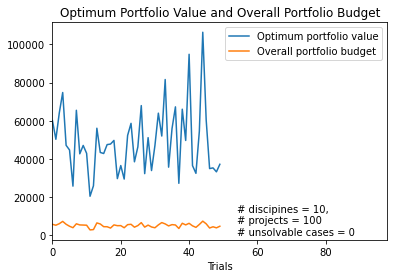

In [8]:
# Plot the portfolio optimum values and overall budgets

# x-axis values 
x = range(n_trials)
# y-axis values 
y = values

# Plot the points 
plt.plot(x, y) 


# x-axis values 
x = range(n_trials)
# y-axis values 
y = budgets

# Plot the points
plt.xlim((min(x), 2*max(x)))
plt.plot(x, y)

# x-axis name
plt.xlabel(F'Trials') 

# Title, text and legends
plt.title(F'Optimum Portfolio Value and Overall Portfolio Budget')
plt.text(1.1*max(x), .025, F'# discipines = {shape[0]},\n# projects = {shape[1]}\n# unsolvable cases = {unsolvable_cases}') 

legends = [F'Optimum portfolio value', F'Overall portfolio budget']
plt.legend(legends, loc='upper right')

plt.show()

In [9]:
# Print the mean and the standard deviation of optimum portfolio values
print(F'Mean = {round(mean(values), 2)}')
print(F'Standard Deviation = {round(stdev(values), 2)}')

Mean = 48913.25
Standard Deviation = 17381.57


In [10]:
# Print the mean and the standard deviation of overall portfolio budgets
print(F'Mean = {round(mean(budgets), 2)}')
print(F'Standard Deviation = {round(stdev(budgets), 2)}')

Mean = 5075.16
Standard Deviation = 1024.59


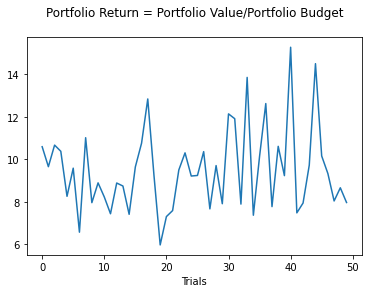

In [11]:
# Calculate and plot the portfolio returns
returns = [-1 for i in range(len(values))]
for i in range(len(values)):
    if budgets[i] != 0: returns[i] = values[i]/budgets[i]
        
# x-axis values 
x = range(n_trials)
# y-axis values 
y = returns

# Plot the points 
plt.plot(x, y)

# x-axis name
plt.xlabel(F'Trials') 

# Title
plt.title(F'Portfolio Return = Portfolio Value/Portfolio Budget\n')

plt.show()

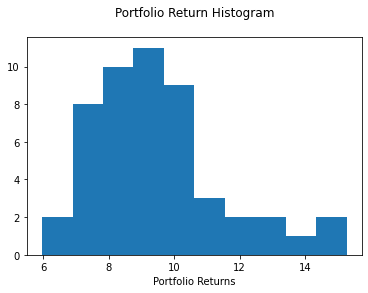

In [12]:
# Plot histogram of portfolio returns
plt.hist(returns)

# x-axis name
plt.xlabel(F'Portfolio Returns') 

# Title
plt.title(F'Portfolio Return Histogram\n')

plt.show()

In [13]:
# Print the mean and the standard deviation of portfolio returns
print(F'Mean = {round(mean(returns), 2)}')
print(F'Standard Deviation = {round(stdev(returns), 2)}')

Mean = 9.48
Standard Deviation = 1.99


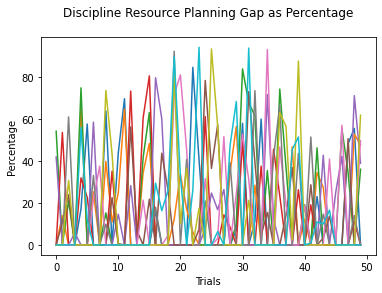

In [14]:
# Plot the planning gaps in disciplines as percentages

# x-axis values 
x = range(n_trials)
# y-axis values 
y = gap_percentage_list

# Plot the points 
plt.plot(x, y)

# x-axis name
plt.xlabel(F'Trials')

# y-axis name
plt.ylabel(F'Percentage')

# Title
plt.title(F'Discipline Resource Planning Gap as Percentage\n')

plt.show()

In [15]:
# Print the means of discipline planning gap percentages
for i in range(shape[0]):
    print(F'Discipline {i+1} Gap Percentage Mean = {round(mean(gap_percentage_list[i]), 2)}')
    # print(F'Discipline {i+1} Gap Percentage Standard Deviation = {round(stdev(gap_percentage_list[i]), 2)}')

Discipline 1 Gap Percentage Mean = 9.63
Discipline 2 Gap Percentage Mean = 7.84
Discipline 3 Gap Percentage Mean = 13.69
Discipline 4 Gap Percentage Mean = 0.57
Discipline 5 Gap Percentage Mean = 24.48
Discipline 6 Gap Percentage Mean = 9.22
Discipline 7 Gap Percentage Mean = 13.88
Discipline 8 Gap Percentage Mean = 3.76
Discipline 9 Gap Percentage Mean = 20.27
Discipline 10 Gap Percentage Mean = 11.21


There seems to be a non-negligible gap in the planning of the discipline resources. This problem can be alleviated to a large extent by having flexibility in skills so that, if needed, resources from one discipline can be reallocated to another one.